# Image to Image Retrieval using CLIP embedding and image correlation reasoning using GPT4V
Alejandro Ricciardi (Omegapy)  
created date: 01/02/2024
GitHub: https://github.com/Omegapy

Projects Description:
Build an Image to Image retrieval program using LlamaIndex with GPT4-V and CLIP.
Tutorial from LlamaIndex.

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts, images, pdf raw files from Wikipedia pages
2. Build Multi-Modal index and vector store for both texts and images
3. Retrieve relevant images given a image query using Multi-Modal Retriever
4. Using GPT4V for reasoning the correlations between the input image and retrieved images

credit: 
[LlamaIndex Youtube video](https://www.youtube.com/watch?v=35RlrrgYDyU)
[Jupyter Notebook: Multi-modal retrieval and querying](https://colab.research.google.com/gist/seldo/e15152f0e7893353b7498331aab6f2f9/image_to_image_retrieval.ipynb#scrollTo=fc691ca8)

#### Installing Dependencies 

In [1]:
%pip install git+https://github.com/run-llama/llama_index.git
# Clip Dependencies 
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
# Matplotlib Dependencies
%pip install matplotlib scikit-image
# qdrant is vector similarity search engine [https://qdrant.tech/documentation/overview/]
%pip install -U qdrant_client
# wikipedia
%pip install wikipedia

  Cloning https://github.com/run-llama/llama_index.git to c:\users\user\appdata\local\temp\pip-req-build-pxm4h9y_
  Resolved https://github.com/run-llama/llama_index.git to commit 8f659705dd7f032e8d204ca860ab654bdf7ab0c3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/run-llama/llama_index.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-pxm4h9y_'
  Running command git submodule update --init --recursive -q


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.Collecting git+https://github.com/openai/CLIP.git
  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-szc_jb9d
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\User\AppData\Local\Temp\pip-req-build-szc_jb9d'


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### API Keys
This project you require API keys from: OpenAI: https://openai.com/

In [2]:
# Load environment variables API Keys
import os
from dotenv import load_dotenv,find_dotenv
load_dotenv(find_dotenv()) 
OPENAI_API_KEY = os.environ.get("OPEN_AI_KEY")

## Download images and texts from Wikipedia

In [3]:
import wikipedia
import urllib.request
from time import time
from pathlib import Path

In [4]:
image_path = Path("mixed_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Vincent_van_Gogh",
    "San_Francisco",
    "Batman",
    "iPhone",
    "Tesla_Model_S",
    "BTS_band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assign UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                # Manages HTTP Error 429: Too many requests.
                try:
                    urllib.request.urlretrieve(url, image_path / f"{image_uuid}.jpg")
                except:
                    time.sleep(1)
                    urllib.request.urlretrieve(url, image_path / f"{image_uuid}.jpg")
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except Exception as e:
        print(e)
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

Vincent_van_Gogh
'builtin_function_or_method' object has no attribute 'sleep'
No images found for Wikipedia page: Vincent_van_Gogh
San_Francisco
'builtin_function_or_method' object has no attribute 'sleep'
No images found for Wikipedia page: San_Francisco
Batman
iPhone
Tesla_Model_S
'builtin_function_or_method' object has no attribute 'sleep'
No images found for Wikipedia page: Tesla_Model_S
BTS_band
'builtin_function_or_method' object has no attribute 'sleep'
No images found for Wikipedia page: BTS_band


### Plot images from Wikipedia

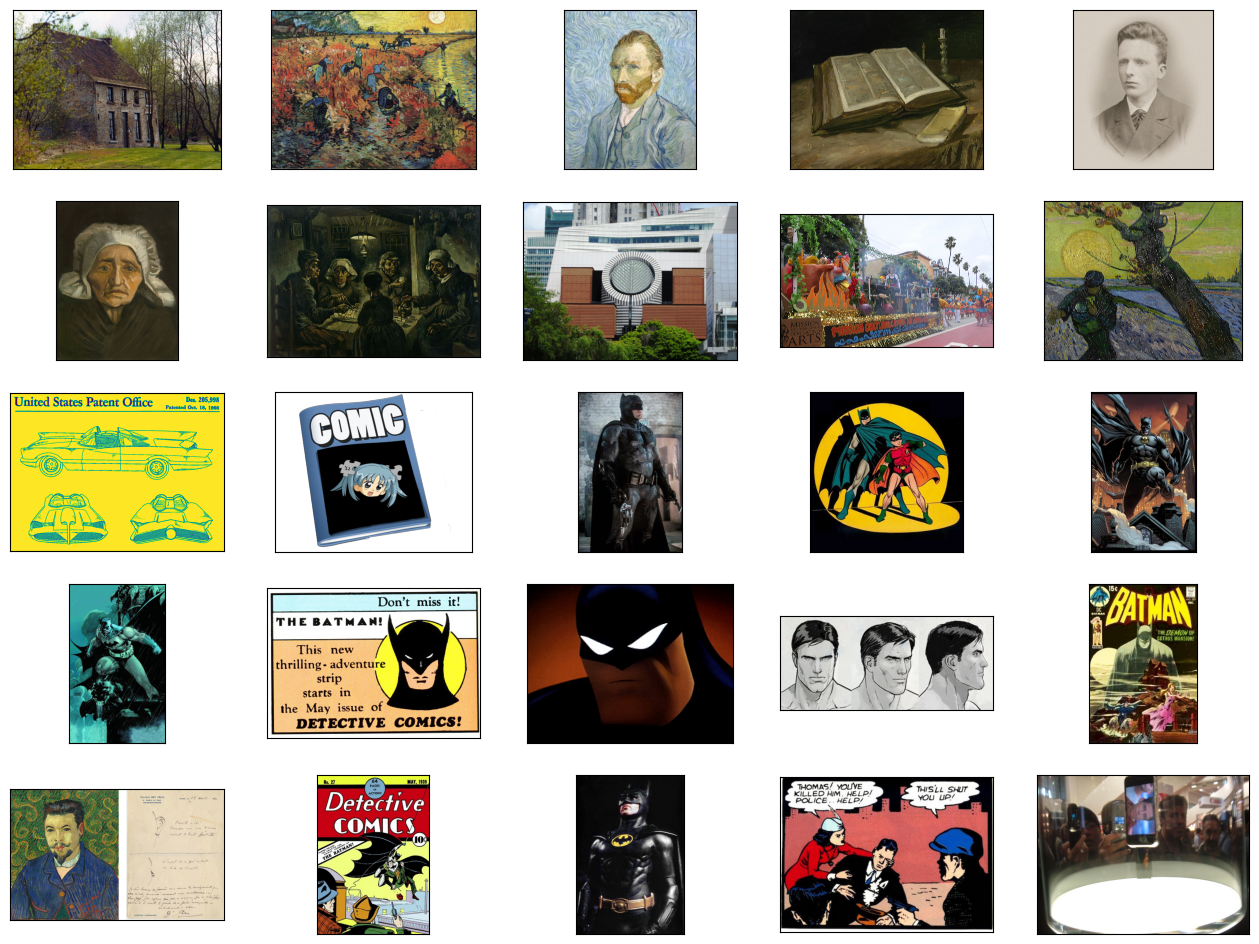

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 12))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(5, 5, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 25:
                break

plot_images(image_paths)

## Build Multi-Modal index and Vector Store to index both text and images from Wikipedia

In [6]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

C:\Users\User\anaconda3\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (101972528 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


### Retrieve images from Multi-Modal Index using an image as the input

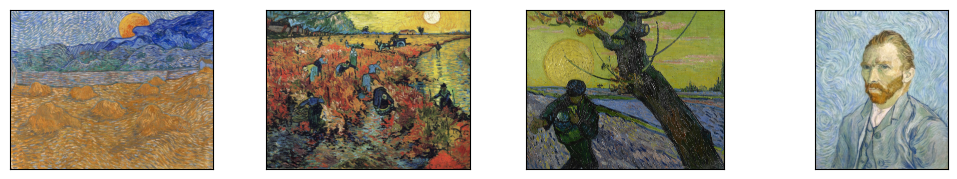

In [7]:
# instantiate a retriever
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# get images semantically similar to our own
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./starry_night.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# display the images we found
plot_images(retrieved_images)

### Query the index using an image and a prompt

In [8]:
from llama_index.prompts import PromptTemplate
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_KEY, max_new_tokens=1500
)

qa_tmpl_str = (
    "Given the images provided, respond to the prompt.\n"
    "Prompt: {query_str}\n"
    "Response: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm, image_qa_template=qa_tmpl,
    similarity_top_k=3, image_similarity_top_k=3
)

query_str = "Tell me more about paintings like this"
response = query_engine.image_query("./starry_night.jpg", query_str)
print(response)

The paintings you've provided are reminiscent of the Post-Impressionist movement, a period in art history that followed the Impressionist movement and started in the late 19th century. This style is characterized by a more deliberate form of expression, often with a greater emphasis on geometric forms, distortion for expressive effect, and the use of unnatural or arbitrary color.

The first image is particularly evocative of Vincent van Gogh's style, with its swirling sky and bright, bold colors. Van Gogh was known for his expressive and emotive use of vivid colors and dynamic brushstrokes. His work often depicted landscapes, night scenes, and still lifes with an intensity that was a departure from the more delicate brushwork of the Impressionists.

The second and third images also share this expressive quality, with visible brushstrokes and a strong use of color to convey mood and atmosphere. The second image shows a scene of rural labor with a vivid sunset, while the third image feat